## Visualize results of the linear model

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))

In [2]:
# Focusing on plate 2
plate <- "localhost220513100001_KK22-05-198_FactinAdjusted"

input_dir <- "results"
lm_file <- file.path(input_dir, paste0(plate, "_linear_model_cp_features.tsv"))
lm_output_file <- file.path(input_dir, paste0(plate, "_linear_model_cp_features_cleaned_sorted.tsv"))

output_fig_dir <- "figures"
lm_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_cp_features.png"))
lm_facet_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_cp_features_bygroup.png"))
lm_coef_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_cp_features_coefficients.png"))

In [3]:
# Load and process linear model data
lm_df <- readr::read_tsv(
    lm_file, col_types = readr::cols(.default = "d", feature = "c")
)

# Arrange by absolute value coefficient
# Split out components of feature name for visualization
lm_df <- lm_df %>%
    dplyr::arrange(desc(abs(treatment_dose_coef))) %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel) %>%
    dplyr::arrange(desc(abs(treatment_dose_coef)))

lm_df$channel_cleaned <- dplyr::recode(lm_df$channel_cleaned,
    "Hoechst" = "DNA",
    "ER" = "ER",
    "Actin" = "Actin",
    "Mitochondria" = "Mito",
    "Golgi" = "Golgi",
    .default = "other",
    .missing = "other"
)

# Output cleaned, parsed, and sorted file
readr::write_tsv(lm_df, lm_output_file)

print(dim(lm_df))
head(lm_df, 3)

Warning message:
“Expected 6 pieces. Additional pieces discarded in 200 rows [1, 3, 4, 5, 7, 8, 9, 13,
15, 18, 19, 21, 25, 28, 29, 30, 31, 32, 34, 35, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 385 rows [2, 6, 10, 11, 12, 14,
16, 17, 20, 22, 23, 24, 26, 27, 33, 36, 37, 39, 40, 41, ...].”


[1] 585  11


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,r2_score,cell_count_coef,treatment_dose_coef,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
Cytoplasm_Texture_InverseDifferenceMoment_Actin_3_01_256,Cytoplasm,Texture,InverseDifferenceMoment,Actin,3,01,0.7426350,-0.0011903452,0.2973030,Actin
Cells_Correlation_K_Mitochondria_Actin,Cells,Correlation,K,Mitochondria,Actin,NA,0.6664501,0.0003628613,-0.2968428,Mito
Cytoplasm_Texture_DifferenceVariance_Actin_3_01_256,Cytoplasm,Texture,DifferenceVariance,Actin,3,01,0.7139563,-0.0009689702,0.2960935,Actin


## Visualize linear modeling results

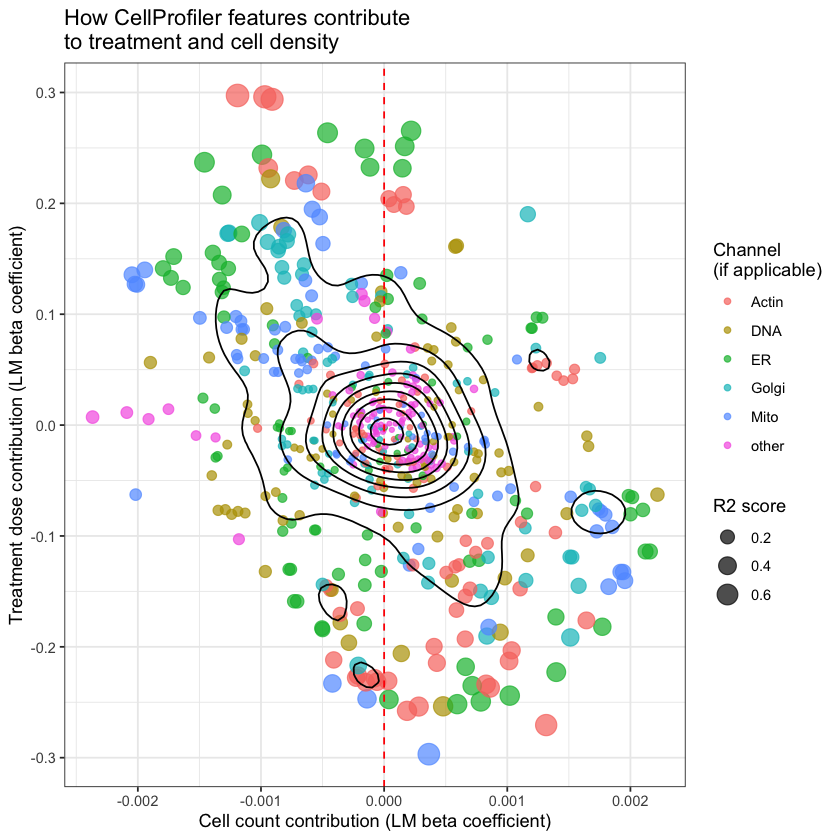

In [4]:
lm_fig_gg <- (
    ggplot(lm_df, aes(x = cell_count_coef, y = treatment_dose_coef))
    + geom_point(aes(size = r2_score, color = channel_cleaned), alpha = 0.7)
    + geom_vline(xintercept = 0, linetype = "dashed", color = "red")
    + geom_density2d(color="black", show.legend = FALSE)
    + theme_bw()
    + guides(
        color = guide_legend(title = "Channel\n(if applicable)", order = 1),
        size = guide_legend(title = "R2 score")
    )
    + ylab("Treatment dose contribution (LM beta coefficient)")
    + xlab("Cell count contribution (LM beta coefficient)")
    + ggtitle("How CellProfiler features contribute\nto treatment and cell density")
)

# Save figure
ggsave(lm_fig, lm_fig_gg, height = 6, width = 6, dpi = 500)

lm_fig_gg

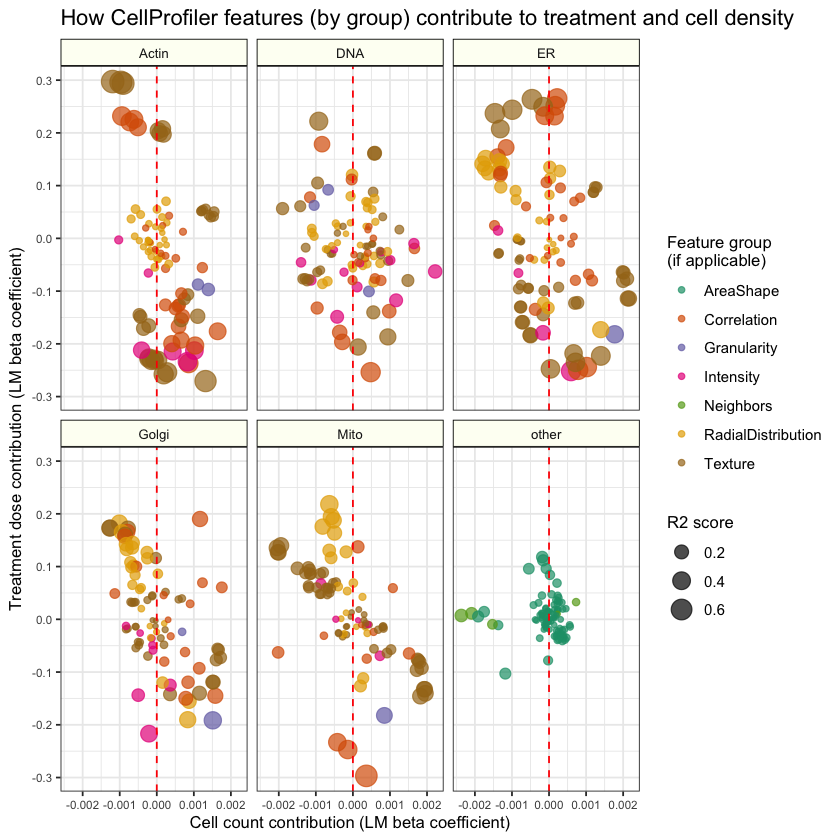

In [5]:
lm_facet_fig_gg <- (
    ggplot(lm_df, aes(x = cell_count_coef, y = treatment_dose_coef))
    + geom_point(aes(size = r2_score, color = feature_group), alpha = 0.7)
    + facet_wrap("~channel_cleaned")
    + geom_vline(xintercept = 0, linetype = "dashed", color = "red")
    + theme_bw()
    + guides(
        color = guide_legend(title = "Feature group\n(if applicable)", order = 1),
        size = guide_legend(title = "R2 score")
    )
    + ylab("Treatment dose contribution (LM beta coefficient)")
    + xlab("Cell count contribution (LM beta coefficient)")
    + ggtitle("How CellProfiler features (by group) contribute to treatment and cell density")
    + scale_color_brewer(palette="Dark2")
    + theme(
        axis.text = element_text(size = 7),
        axis.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.title = element_text(size = 10),
        strip.text = element_text(size = 8),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
)

# Save figure
ggsave(lm_facet_fig, lm_facet_fig_gg, height = 6, width = 8, dpi = 500)

lm_facet_fig_gg

## Visualize LM coefficients by group

In [6]:
channels <- c(
    "Mitochondria" = "Mito",
    "Hoechst" = "DNA",
    "Golgi" = "Golgi",
    "ER" = "ER",
    "Actin" = "Actin"
)

lm_cleaned_df <- lm_df %>%
    dplyr::filter(channel %in% names(channels)) %>%
    dplyr::group_by(feature_group, channel_cleaned, compartment) %>%
    dplyr::slice_max(order_by = treatment_dose_coef, n = 1)

head(lm_cleaned_df, 3)

feature,compartment,feature_group,measurement,channel,parameter1,parameter2,r2_score,cell_count_coef,treatment_dose_coef,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
Cells_Correlation_Correlation_Actin_Hoechst,Cells,Correlation,Correlation,Actin,Hoechst,NA,0.00607165,-0.0002984381,0.01965727,Actin
Cytoplasm_Correlation_K_Actin_Golgi,Cytoplasm,Correlation,K,Actin,Golgi,NA,0.40588465,-0.0006164611,0.22567088,Actin
Nuclei_Correlation_K_Actin_ER,Nuclei,Correlation,K,Actin,ER,NA,0.45297673,-0.0009412647,0.23191057,Actin


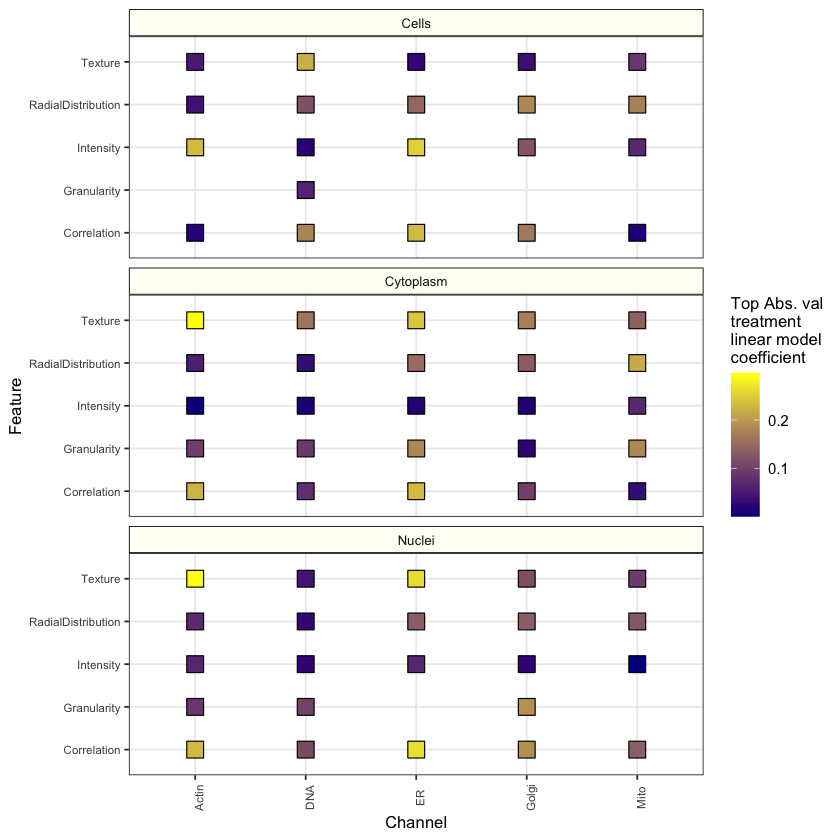

In [7]:
coef_gg <- (
    ggplot(lm_cleaned_df, aes(x = channel_cleaned, y = feature_group))
    + geom_point(aes(fill = abs(treatment_dose_coef)), pch = 22, size = 5)
    + facet_wrap("~compartment", ncol = 1)
    + theme_bw()
    + scale_fill_gradient(
        name="Top Abs. val\ntreatment\nlinear model\ncoefficient",
        low = "darkblue",
        high = "yellow"
    )
    + xlab("Channel")
    + ylab("Feature")
    + theme(
        axis.text = element_text(size = 7),
        axis.text.x = element_text(angle = 90, size = 7),
        axis.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.title = element_text(size = 10),
        strip.text = element_text(size = 8),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
)

# Save figure
ggsave(lm_coef_fig, coef_gg, height = 5, width = 3.5, dpi = 500)

coef_gg